In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, fft

In [2]:
fs = 2e6
sps = 4
fsym = fs/sps
print(f"Symbol Rate = {fsym}")

rx_samples = np.fromfile("usrp_rx_shift_LPF.iq", np.complex64)
rx_burst = np.fromfile("usrp_rx_shift_LPF_1burst.iq", np.complex64)

Symbol Rate = 500000.0


In [3]:
# Plot to see what's going on
rx_samples = rx_samples[0:int(6*fs)]  #Remove high power competing signal and shorten signal
sig_power = 20*np.log(np.average(np.abs(rx_burst)))
avg_power = 20*np.log(np.average(np.abs(rx_samples)))
print(f"Sig power: {sig_power}")
print(f"AVG Power: {avg_power}")
print(f"SNR: {sig_power - avg_power}")

Sig power: 39.42161321640015
AVG Power: -161.0710334777832
SNR: 200.49264669418335


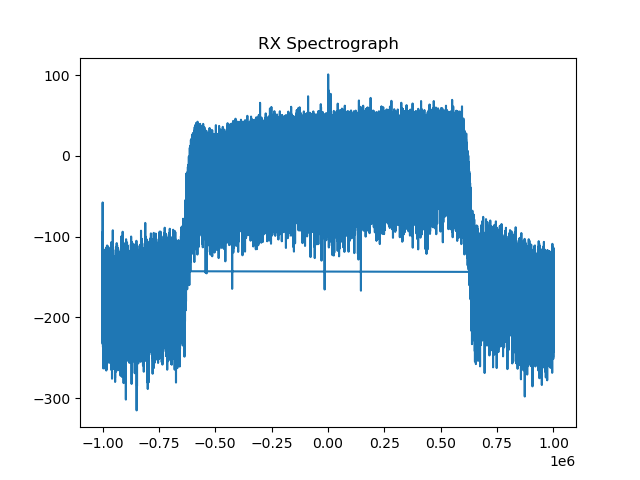

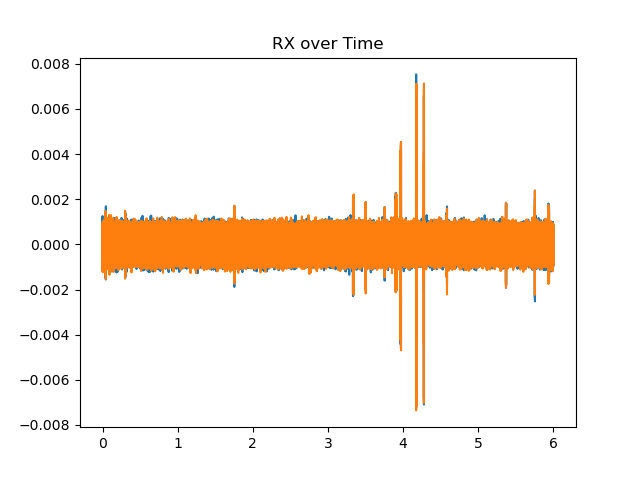

In [4]:
#PLot RX
t = np.arange(0, len(rx_samples)/fs, 1/fs)
%matplotlib widget
plt.figure("RX over Time")
plt.title("RX over Time")
plt.plot(t, rx_samples.real)
plt.plot(t, rx_samples.imag)
plt.show

yf = fft.fft(rx_samples)
freqs = fft.fftfreq(rx_samples.size, d=1/fs)

plt.figure("RX Spectrograph")
plt.title("RX Spectrograph")
plt.plot(freqs, 20*np.log(np.abs(yf)))
plt.show()
#plt.figure("PWR over Time")
#plt.title("PWR over Time")
#plt.plot(t, 20*np.log(np.abs(rx_samples)))
#plt.show()

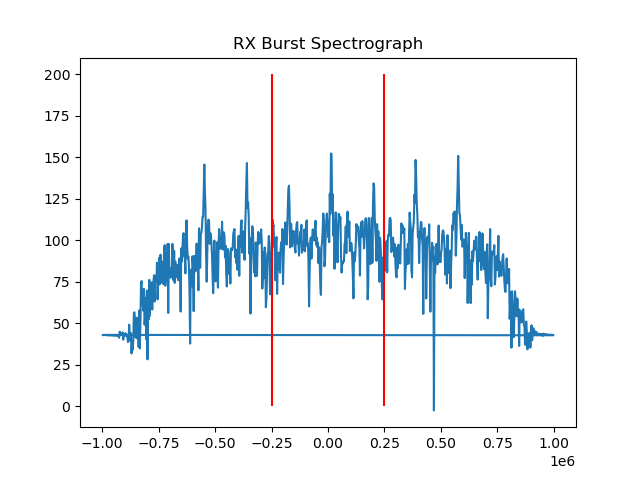

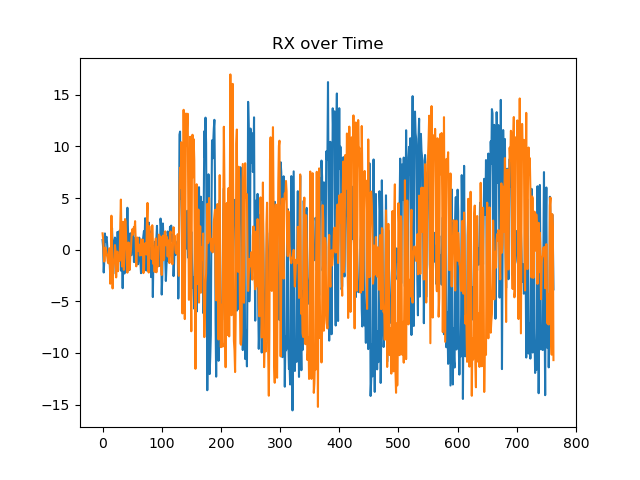

In [5]:
# PLot Burst
%matplotlib widget
plt.figure("RX Burst over Time")
plt.title("RX over Time")
plt.plot(rx_burst.real)
plt.plot(rx_burst.imag)
plt.show

yf = fft.fft(rx_burst)
freqs = fft.fftfreq(rx_burst.size, d=1/fs)

plt.figure("RX Burst Spectrograph")
plt.title("RX Burst Spectrograph")
plt.plot(freqs, 20*np.log(np.abs(yf)))
plt.vlines([fsym/2, -fsym/2], 200, 0, 'r')
plt.show()

In [6]:

#Calculate & verify alpha for IIR filter in squelch
# Per the charecteristics of the RRC and the red lines in RX Burst Spectrograph
# the squelch IIR needs to be tuned to a freq cutoff at +/symbol_rate/2
# Reference this: https://dsp.stackexchange.com/questions/28308/3-db-cut-off-frequency-of-exponentially-weighted-moving-average-filter
# Also this: https://en.wikipedia.org/wiki/Exponential_smoothing

#The time constant needs to be calulated from the total possible burst length

alpha = 1-np.exp(-fs/(fsym*256*1.1))
#alpha /= 100000
print(f"Alpha {alpha}")


# Try filter
rx_mag = np.abs(rx_samples)**2
print(len(rx_mag))
filtered = np.zeros(rx_mag.shape)
filtered[0] = rx_mag[0]

for i in range(1, len(rx_mag)):
    filtered[i] = alpha * rx_mag[i] + (1-alpha)*filtered[i-1]




Alpha 0.01410413688037182
12000000


Threshold 3.162277660168379e-07


<function matplotlib.pyplot.show(block=None)>

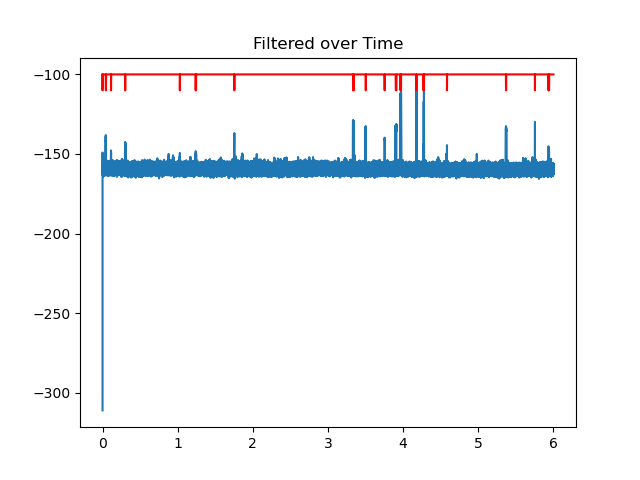

In [11]:
threshold_db = -65
threshold = 10**(threshold_db/10)
print(f"Threshold {threshold}")

burst = np.ones(rx_mag.shape) * -100
burst[filtered >= threshold] = -110
# PLot Filter
t = np.arange(0, len(filtered)/fs, 1/fs)
%matplotlib widget
plt.figure("Filtered over Time")
plt.title("Filtered over Time")
#plt.plot(t, filtered)#10*np.log(filtered))
plt.plot(t, 10*np.log(filtered))
plt.plot(t, burst, 'r')
#plt.plot(t, rx_mag)
plt.show